<a href="https://colab.research.google.com/github/richtotti/Distributed-Image-Processing-in-Cloud-Dataproc/blob/master/workSpace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#Install these libraries
!pip install -U sentence-transformers
!pip install pyxlsb
!pip install clusteval

     |████████████████████████████████| 92kB 3.1MB/s 
     |████████████████████████████████| 2.5MB 18.5MB/s 
     |████████████████████████████████| 1.2MB 43.3MB/s 
     |████████████████████████████████| 901kB 55.9MB/s 
     |████████████████████████████████| 3.3MB 52.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-cp37-none-any.whl size=126711 sha256=9d3a4c051f53974b69f1097af8e3eb5ab82fc5138c8741c33d7dff57adac41eb
  Stored in directory: /root/.cache/pip/wheels/38/d2/98/d191289a877a34c68aa67e05179521e060f96394a3e9336be6
Successfully built sentence-transformers
ERROR: transformers 4.8.2 has requirement huggingface-hub==0.0.12, but you'll have huggingface-hub 0.0.13 which is incompatible.
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=8a66d034f6123fe86023a45909dd5e952a79d9a5d7ee8112781f43870c3546f8
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully

In [5]:
import pandas as pd
import re
from sklearn.feature_extraction import stop_words
from string import punctuation as punc
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from clusteval import clusteval
nltk.download('wordnet')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [6]:
# Read the files then merge using pandas 
df_telemedicine = pd.read_excel('telemedicine.xlsx')
df_telehealth = pd.read_excel('telehealth.xlsb',engine='pyxlsb')
df_merge = pd.merge(df_telemedicine,df_telehealth,indicator=True,how='outer')
df_merge.head()

,Title,Authors,Published,Topic,Journal,Abstract,_merge
0,Telemedicine technology and clinical applicati...,"D. Perednia, A. Allen,",1995-02-08 00:00:00,Medicine,JAMA,TELEMEDICINE can be broadly defined as the use...,left_only
1,On the definition and evaluation of telemedicine.,"R. Bashshur,",1995,Medicine,Telemedicine journal : the official journal of…,Issues related to the definition and evaluatio...,left_only
2,"Telemedicine: history, applications, and impac...","Zundel Km,",NaN,NaN,NaN,TLDR\nThis paper traces the uses of telecommun...,left_only
3,Telemedicine: a cautious welcome,"R. Wootton,",1996-11-30 00:00:00,"Computer Science, Medicine",BMJ,Telemedicine is a major new development. Havin...,left_only
4,Pilot studies of telemedicine for patients wit...,"L. Baer, P. Cukor, M. Jenike, L. Leahy, J. O'L...",1995-09-01 00:00:00,"Psychology, Medicine",The American journal of psychiatry,OBJECTIVE Remote video psychiatric assessment ...,left_only


In [7]:
# Preprocessing
lemma = WordNetLemmatizer()
st = PorterStemmer()
stopWordsList=list(stop_words.ENGLISH_STOP_WORDS)

def pre_processing(abstract):
    abstract = re.sub("[0123456789]","",abstract) #remove the numbers
    endl = re.sub("\n"," ",abstract) #remove the endline
    removePuncList = re.sub("["+punc+"]","",endl) #remove punctuations
    currentList = removePuncList.split(" ")
    removeStopWordsList = [word for word in currentList if word not in stopWordsList] #remove stopwords
    stemList = []
    for word in removeStopWordsList:        
        stemList.append(lemma.lemmatize(st.stem(word),'v')) # stemming and lematization    
    return " ".join(stemList)


In [8]:
abstract_list = df_merge['Abstract'].dropna().to_list() #Only abstract convert into list from dataframe and nan remove in abstract
abstract_list = [pre_processing(abstract).strip() for abstract in abstract_list] #pre processing apply on each abstract

In [9]:
#SentenceTransformer model convert the sentence into vecotor format and lenght of each vector is 768
model = SentenceTransformer('paraphrase-distilroberta-base-v1')
embedding_abstract_list = model.encode(abstract_list)

In [10]:
#TSNE model is reduce the dimensionality of vector and n_components means it will return the 2-dimension vector
X_embedded_abstract_list = TSNE(n_components=2,perplexity=50.0).fit_transform(embedding_abstract_list)


[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward


  0%|          | 0/23 [00:00<?, ?it/s]

[clusteval] >Evaluate using silhouette.


100%|██████████| 23/23 [03:50<00:00, 10.03s/it]


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [2].
[clusteval] >Fin.


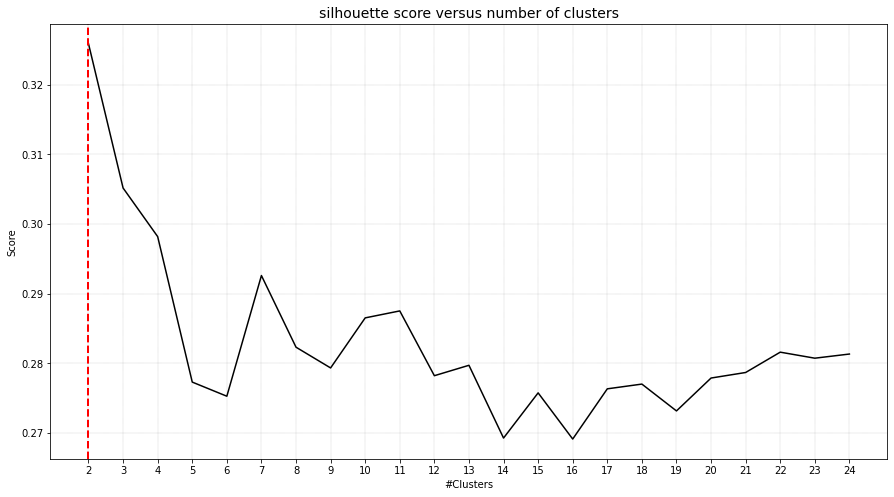

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa2ba3b1290>)

In [11]:
#Cluster validation using silhouette and tell us how many best number of clusters will use for this data
ce = clusteval(method='silhouette')
ce.fit(X_embedded_abstract_list)
ce.plot()


[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using derivatives.
[clusteval] >Determining optimal clustering by derivatives..
[clusteval] >Clusters: 4
[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [3].
[clusteval] >Fin.


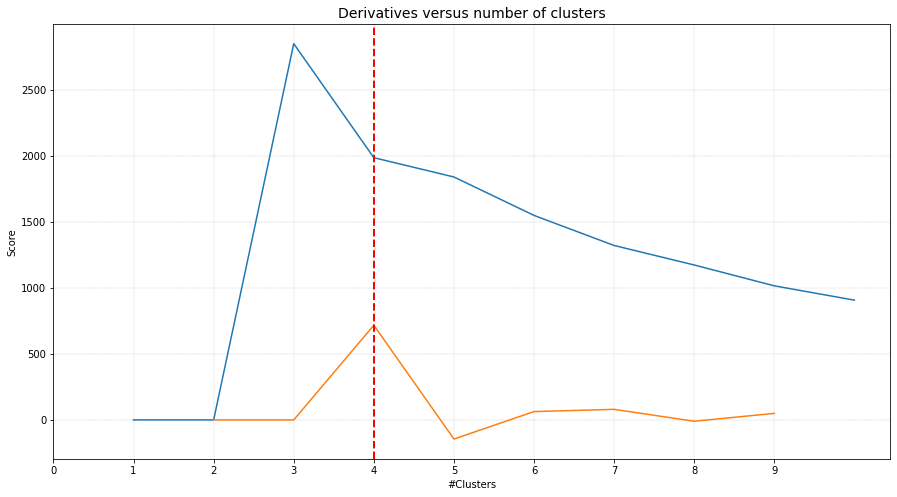

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa2b0722990>)

In [12]:
#Cluster validation using derivative and tell us how many best number of clusters will use for this data
ce = clusteval(method='derivative')
ce.fit(X_embedded_abstract_list)
ce.plot()


[clusteval] >Fit using dbscan with metric: euclidean, and linkage: ward


  0%|          | 0/245 [00:00<?, ?it/s]

[clusteval] >Normalize data (unit variance, zero-mean).
[clusteval] >Gridsearch across epsilon..
[clusteval] >Evaluate using silhouette..


100%|██████████| 245/245 [17:59<00:00,  4.40s/it]


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [2].
[clusteval] >Fin.


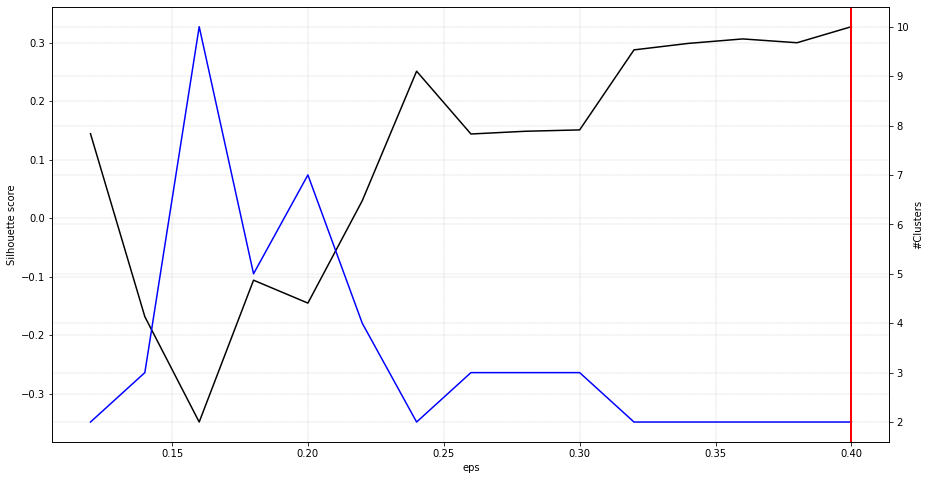

(<Figure size 1080x576 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7fa2b011ab10>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fa2b06e1250>))

In [13]:
#Cluster validation using dbscan
ce = clusteval(cluster='dbscan')
ce.fit(X_embedded_abstract_list)
ce.plot()

In [14]:
#Kmeans model for clusterting
y_pred = KMeans(n_clusters=3, max_iter=1000, random_state=0).fit_predict(X_embedded_abstract_list)

Text(0, 0.5, 'TSNE_2')

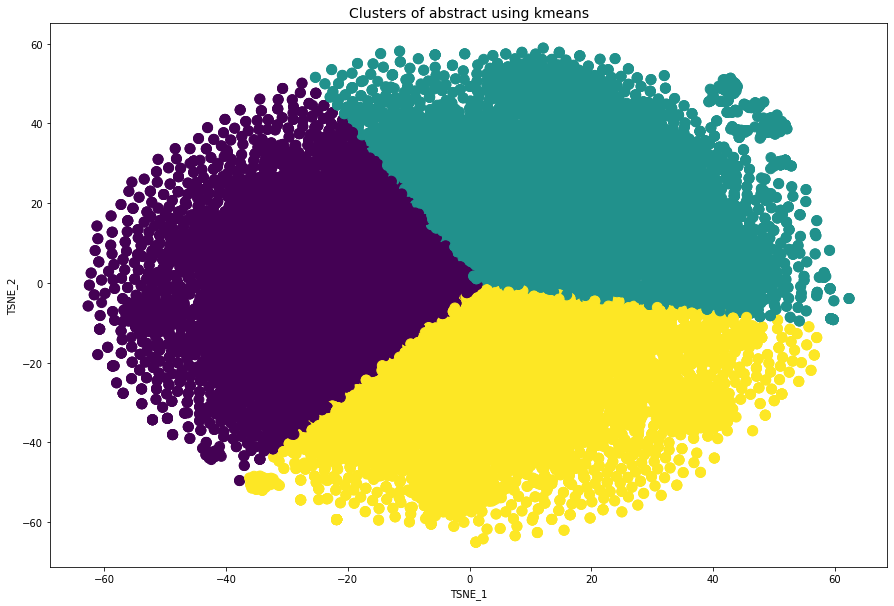

In [15]:
#Plot the graph
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(X_embedded_abstract_list[:, 0], X_embedded_abstract_list[:, 1], s=100,c=y_pred)
plt.title("Clusters of abstract using kmeans")
plt.xlabel("TSNE_1")
plt.ylabel("TSNE_2")